In [2]:
import sys
import argparse

sys.argv = ["view", "--config", "../../config/single_task_object_detection.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

../../config/single_task_object_detection.yaml


In [3]:
from dataloader import VOC08Attr
from torchvision.transforms import transforms
from config_experiments import config
from bbox_transform import relative_to_absolute_bbox

In [4]:
transform_train = transforms.Compose(
    [
        transforms.Resize(size=(600, 600)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config["transform"]["mean"], std=config["transform"]["std"]
        ),
    ]
)

In [5]:
import torch
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import numpy as np


def show(imgs):
    plt.rcParams["savefig.bbox"] = "tight"
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)  # (H, W)
        axs[0, i].imshow(np.asarray(img))  # (W, H, 3)
        # axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) # uncomment to remove axis in plot


def show_bounding_box(img_tensor, box, labels=None, color="white"):
    img_tensor = inverse_transform(img_tensor)
    show(draw_bounding_boxes(img_tensor, box, colors=color, labels=labels, width=1))


def show_bbox_with_transform(img, box, mean, std, labels=None, color="white"):
    img = inverse_transorm_with_normalize(img, mean, std)
    show(draw_bounding_boxes(img, box, colors=color, labels=labels, width=2))


def inverse_transorm_with_normalize(image, mean, std):
    image = np.array(image)
    for channel in range(3):
        image[channel] = image[channel] * std[channel] + mean[channel]
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = torch.from_numpy(image)
    return image


def inverse_transform(image):
    image = np.array(image)
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = torch.from_numpy(image)
    return image

torch.Size([3, 600, 600])
(500, 327)
tensor([[0.5400, 0.0031, 0.7540, 0.5352],
        [0.1140, 0.0031, 0.3280, 0.4557]])


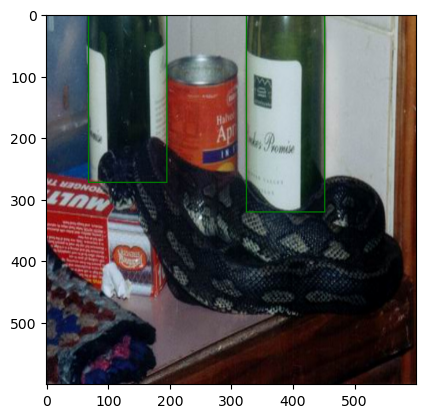

In [28]:
data_train = VOC08Attr(root="../../", train=True, transform=transform_train)
image, img_size, gt_class, gt_bbox, gt_attributes, ss_rois = data_train[1]
print(image.shape)
print(img_size)
print(gt_bbox)
gt_bbox = relative_to_absolute_bbox(gt_bbox, (600, 600))
show_bbox_with_transform(
    image,
    gt_bbox,
    mean=config["transform"]["mean"],
    std=config["transform"]["std"],
    color="green",
)

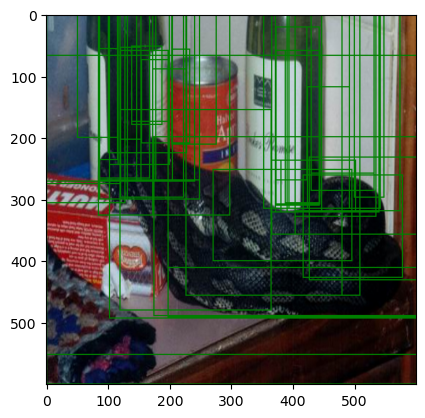

In [7]:
from torch.utils.data import DataLoader
from dataloader import collate_fn

train_dataloader = DataLoader(
    data_train, batch_size=config["preprocessing"]["n_images"], collate_fn=collate_fn
)
images, rois, classes, offsets, attrs, indices_batch = next(iter(train_dataloader))
i = 1
img_indices = indices_batch.view(-1) == i
rois = relative_to_absolute_bbox(
    rois[img_indices], config["transform"]["resize_values"]
)
show_bbox_with_transform(
    images[i],
    rois,
    mean=config["transform"]["mean"],
    std=config["transform"]["std"],
    color="green",
)